In [1058]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold

In [1059]:
# path = '/content/content/MyDrive/[ML DL] data/[Dacon]전력사용량 예측 AI 경진대회/'
path = ''

train = pd.read_csv(path + 'Train_for_model.csv', encoding='utf-8')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv(path + 'Test_for_model.csv', encoding='utf-8')
test['date_time'] = pd.to_datetime(test['date_time'])

test = test.interpolate()

In [1060]:
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
118075,60,2020-08-21 19:00:00,3780.000,27.0,1.9,77.0,0.0,0.1,1,1
118076,60,2020-08-21 20:00:00,3691.440,26.0,2.6,82.0,0.0,0.0,1,1
118077,60,2020-08-21 21:00:00,3532.896,25.2,2.2,83.0,0.0,0.0,1,1
118078,60,2020-08-21 22:00:00,3411.504,24.9,2.4,84.0,0.0,0.0,1,1


In [1061]:
test

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-08-22 00:00:00,8646.264,25.2,1.9,87,0.0,0.0,0,0
1,1,2020-08-22 01:00:00,8637.192,25.0,2.0,86,0.0,0.0,0,0
2,1,2020-08-22 02:00:00,8616.456,25.0,1.4,86,0.0,0.0,0,0
3,1,2020-08-22 03:00:00,8592.480,24.7,1.8,86,0.0,0.0,0,0
4,1,2020-08-22 04:00:00,8570.448,24.4,1.7,87,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
4315,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68,0.0,0.7,1,1
4316,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71,0.0,0.0,1,1
4317,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71,0.0,0.0,1,1
4318,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74,0.0,0.0,1,1


In [1062]:
col_name = ['num', 'date_time', 'y', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']

train = pd.DataFrame(train.values, columns=col_name)
test = pd.DataFrame(test.values, columns=col_name)

In [1063]:
train['weekday'] = train.date_time.apply(lambda x: x.weekday())
train['hour'] = train.date_time.apply(lambda x: str(x.time())[:2])

test['weekday'] = test.date_time.apply(lambda x: x.weekday())
test['hour'] = test.date_time.apply(lambda x: str(x.time())[:2])

In [1064]:
def holiday(data):
    if data == 6 or data == 7: return 0
    else: return 1
    
train['holiday'] = train['weekday'].apply(lambda x: holiday(x))
test['holiday'] = test['weekday'].apply(lambda x: holiday(x))

In [1065]:
#체감온도, 불쾌지수

def get_pow(series):
    return math.pow(series, 0.15)

train['perceived_temperature'] = 13.12 + 0.6215*train['temp'] - 11.37*train['wind'].apply(get_pow) + 0.3965*train['wind'].apply(get_pow)*train['temp']
train['discomfort_index'] = 1.8*train['temp'] - 0.55*(1-train['humidity']/100)*(1.8*train['temp']-26) + 32

test['perceived_temperature'] = 13.12 + 0.6215*test['temp'] - 11.37*test['wind'].apply(get_pow) + 0.3965*test['wind'].apply(get_pow)*test['temp']
test['discomfort_index'] = 1.8*test['temp'] - 0.55*(1-test['humidity']/100)*(1.8*test['temp']-26) + 32

In [1066]:
train['monday'] = train['weekday'].apply(lambda x: 1 if x == 0 else 0)
test['monday'] = test['weekday'].apply(lambda x: 1 if x == 0 else 0)

In [1067]:
# train_37 = train[train['num'] == 37]
# y = train_37['y'].reset_index(drop=True)
# X = train_37.drop(['date_time', 'y', 'num', 'cold_system', 'sun_system'], axis = 1).reset_index(drop=True)

# test_37 = test[test['num'] == 37]
# y_true = test_37['y'].reset_index(drop=True)
# X_test = test_37.drop(['date_time', 'y', 'num', 'cold_system', 'sun_system'], axis = 1).reset_index(drop=True)

In [1068]:
hour_y = np.array(y).reshape(-1, 24).T

scaler = StandardScaler()
scaler.fit(hour_y)
hour_y = scaler.transform(hour_y)

In [1069]:
pca = PCA(n_components=3)
pca.fit(hour_y)
pca_hour_y = pca.transform(hour_y)

pca.explained_variance_ratio_

array([0.74987067, 0.14041528, 0.07759413])

In [1070]:
scaler = StandardScaler()
scaler.fit(pca_hour_y)
pca_hour_y = scaler.transform(pca_hour_y)

In [1071]:
# n_cluster = [3, 4, 5, 6]

# for i in n_cluster:
#     kmeans = KMeans(n_clusters=i, init='k-means++')
#     kmeans.fit(pca_hour_y)
#     clusters = kmeans.predict(pca_hour_y)

#     print(f'Cluster:{i}\tScore:{silhouette_score(pca_hour_y, clusters):.4f}')

In [1072]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(pca_hour_y)
clusters = kmeans.predict(pca_hour_y)

In [1073]:
hour_df = pd.DataFrame(train['hour'].unique(), columns=['hour'])
hour_df['cluster'] = clusters

In [1074]:
train = train.merge(hour_df, how='left', on='hour')
test = test.merge(hour_df, how='left', on='hour')

In [1075]:
train['drop_idx'] = train['date_time'].apply(lambda x: 0 if str(x.date()) == '2020-08-17' else 1)

In [1076]:
train = train[train['drop_idx'] == 1]

In [1077]:
train_37 = train[train['num'] == 37]
y = train_37['y'].reset_index(drop=True)
X = train_37.drop(['date_time', 'y', 'num', 'cold_system', 'sun_system', 'drop_idx'], axis = 1).reset_index(drop=True)

test_37 = test[test['num'] == 37]
y_true = test_37['y'].reset_index(drop=True)

X_test = test_37.drop(['date_time', 'y', 'num', 'cold_system', 'sun_system'], axis = 1).reset_index(drop=True)

In [793]:
plot_columns = ['y', 'temp', 'wind', 'humidity', 'rain', 'sun', 'perceived_temperature', 'discomfort_index']

fig = px.line(train_37, x='date_time', y=plot_columns)
fig.show()

In [796]:
fig = px.line(train_37, x='date_time', y='y', color='cluster')
fig.show()

In [779]:
hist_data = []
group_labels = []

for i in range(7):
    data = np.array(train_37[train_37['weekday'] == i]['y'], float)
    label = f'weekday {i}'
    hist_data.append(data)
    group_labels.append(label)

In [785]:
fig = ff.create_distplot(hist_data, group_labels, bin_size=.10, show_hist=False)
fig.show()

In [1079]:
# scale_columns = ['weekday', 'hour', 'holiday', 'cluster', 'monday']

scaler = RobustScaler()
scaler.fit(X.drop('weekday', axis=1))
X = scaler.transform(X.drop('weekday', axis=1))
X_test = scaler.transform(X_test.drop('weekday', axis=1))

In [1080]:
col_name = ['temp', 'wind', 'humidity', 'rain', 'sun', 'hour', 'holiday', 'perceived_temperature', 'discomfort_index', 'cluster', 'monday']


X = pd.DataFrame(X, columns=col_name)
X_test = pd.DataFrame(X_test, columns=col_name)

In [1081]:
X

,temp,wind,humidity,rain,sun,hour,holiday,perceived_temperature,discomfort_index,cluster,monday
0,-0.954545,0.818182,-0.44,0.0,0.0,-1.000000,0.0,-1.148378,-1.240212,1.0,-0.5
1,-1.590909,0.454545,0.52,0.7,0.0,-0.913043,0.0,-1.802423,-1.812723,1.0,-0.5
2,-1.636364,-0.454545,0.68,0.4,0.0,-0.826087,0.0,-1.674434,-1.852810,1.0,-0.5
3,-1.590909,0.090909,0.68,0.5,0.0,-0.739130,0.0,-1.750380,-1.794481,1.0,-0.5
4,-1.545455,0.000000,0.68,0.0,0.0,-0.652174,0.0,-1.687080,-1.736151,1.0,-0.5
...,...,...,...,...,...,...,...,...,...,...,...
1939,0.636364,0.727273,0.20,0.0,0.0,0.652174,0.0,0.591513,0.806970,0.0,0.0
1940,0.545455,0.272727,0.12,0.0,0.0,0.739130,0.0,0.503042,0.657145,0.0,0.0
1941,0.363636,0.454545,0.28,0.0,0.0,0.826087,0.0,0.302651,0.520384,0.0,0.0
1942,0.318182,-0.363636,0.32,0.0,0.0,0.913043,0.0,0.294031,0.484476,0.0,0.0


In [1082]:
week_train = pd.DataFrame(train[train['num'] == 37].weekday.values, columns=['weekday'])
week_test = pd.DataFrame(test[test['num'] == 37].weekday.values, columns=['weekday'])

In [1083]:
X = pd.concat([X, week_train], axis=1)
X_test = pd.concat([X_test, week_test], axis=1)

In [1085]:
y = np.array(y)
y = pd.Series(y).astype('float32')
y_true = y_true.astype('float32')

In [1089]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*200

In [1090]:
n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(X_test))
fold = 1

# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for tr_idx, val_idx in sfk.split(X, X['weekday']):
    print('======== {}fold ========'.format(fold))
    X_train = X.iloc[tr_idx, :]
    y_train = y[tr_idx]

    X_val = X.iloc[val_idx, :]
    y_val = y[val_idx]
    
#     print(X_val.index)
    
#     rf = RandomForestRegressor(n_estimators = 1000)
#     rf.fit(X_train, y_train)
#     y_pred += rf.predict(X_test) / n_splits
#     pred = lgbm.predict(X_test)    
    
    lgbm = LGBMRegressor(n_estimators = 1000, learning_rate= 0.01,objective = 'mse')
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds= 100,verbose = 500)
    y_pred += lgbm.predict(X_test) / n_splits
    pred = lgbm.predict(X_test)
    
    print(f'\nSMAPE: {SMAPE(y_true, pred):.4f}\n')
    
    fold += 1

======== 1fold ========
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[298]	valid_0's rmse: 146.828	valid_0's l2: 21558.4

SMAPE: 2.9008

======== 2fold ========
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[288]	valid_0's rmse: 136.829	valid_0's l2: 18722.2

SMAPE: 2.3355

======== 3fold ========
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 107.73	valid_0's l2: 11605.7
Early stopping, best iteration is:
[452]	valid_0's rmse: 106.977	valid_0's l2: 11444.1

SMAPE: 2.6148

======== 4fold ========
Training until validation scores don't improve for 100 rounds
[500]	valid_0's rmse: 111.279	valid_0's l2: 12382.9
Early stopping, best iteration is:
[782]	valid_0's rmse: 110.22	valid_0's l2: 12148.5

SMAPE: 3.8556

======== 5fold ========
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[372]	valid_0's rmse:

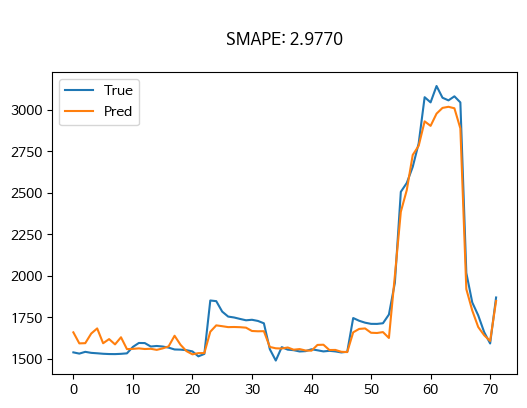

In [1092]:
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Pred')
plt.title(f'\nSMAPE: {SMAPE(y_true, y_pred):.4f}\n')
plt.legend()
plt.show()